In [118]:
import requests
import pandas as pd
import datetime

# 1) Get Bitcoin data with an API and save as CSV 

In [119]:
def get_bitcoin_df(time_frame="1m"):
    base_url= "https://api.gemini.com"
    api_version = "v2"
    symbol = "btcusd"

    url = f"{base_url}/{api_version}/candles/{symbol}/{time_frame}"
    response = requests.get(url=url)
    
    # Make the dataframe
    bitcoin_df = pd.DataFrame(response.json())
    bitcoin_df.columns =[
        "time",
        "open_price",
        "high_price",
        "low_price",
        "close_price",
        "volume",
    ]
    # Transform time format
    bitcoin_df["time"] = bitcoin_df["time"].apply(
            lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
    )
    # Save as a csv file with the current_time as the name
    current_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    bitcoin_df.to_csv(f'timeseries_csv/{current_time}.csv') 
    return bitcoin_df

In [120]:
get_bitcoin_df()
# everytime you run this function you create a new csv file with updated Bitcoin data

,time,open_price,high_price,low_price,close_price,volume
0,2021-12-24 17:08:00,51219.73,51219.73,51186.04,51208.67,0.147812
1,2021-12-24 17:07:00,51152.31,51219.94,51152.31,51219.73,2.049527
2,2021-12-24 17:06:00,51106.09,51152.31,51106.09,51152.31,0.332815
3,2021-12-24 17:05:00,51035.50,51106.09,51034.36,51106.09,0.092917
4,2021-12-24 17:04:00,50978.04,51035.54,50978.04,51035.50,0.382551
...,...,...,...,...,...,...
1436,2021-12-23 17:12:00,48923.76,48942.29,48917.81,48937.08,0.530868
1437,2021-12-23 17:11:00,48930.86,48945.21,48920.29,48923.76,0.032294
1438,2021-12-23 17:10:00,48906.44,48946.08,48906.44,48930.86,0.017247
1439,2021-12-23 17:09:00,48979.70,48979.70,48906.44,48906.44,0.424899


In [121]:
from dask import dataframe as ddf

In [122]:
all_historical_data = ddf.read_csv('timeseries_csv/*.csv').compute()
# read all csv files in timseries_csv folder

In [123]:
all_historical_data_drop_reset = all_historical_data.drop_duplicates(subset=['time']).reset_index(drop=True)
del all_historical_data_drop_reset['Unnamed: 0']
# drop duplicates in time colum and reset index
all_historical_data_drop_reset

,time,open_price,high_price,low_price,close_price,volume
0,2021-12-24 15:57:00,50928.76,50928.76,50886.40,50886.41,0.049171
1,2021-12-24 15:56:00,51034.80,51034.80,50867.67,50928.76,4.129157
2,2021-12-24 15:55:00,51012.44,51075.16,51012.44,51034.80,0.301463
3,2021-12-24 15:54:00,51167.06,51167.06,51001.00,51012.44,9.149670
4,2021-12-24 15:53:00,51168.46,51206.47,51167.06,51167.06,1.062529
...,...,...,...,...,...,...
1507,2021-12-24 16:58:00,50974.81,50974.81,50948.00,50964.82,0.900322
1508,2021-12-24 16:57:00,50982.78,50982.78,50943.33,50974.81,0.341640
1509,2021-12-24 16:56:00,51013.51,51014.56,50974.88,50982.78,1.922774
1510,2021-12-24 16:55:00,50905.62,51013.51,50905.62,51013.51,4.065283


# 2) Import Prophet and train model

In [124]:
from prophet import Prophet

In [125]:
prophet_df = all_historical_data_drop_reset[['time','close_price']]
prophet_rename = prophet_df.rename(columns={"time": "ds", "close_price": "y"})
# format df for Prophet

In [126]:
prophet_rename

,ds,y
0,2021-12-24 15:57:00,50886.41
1,2021-12-24 15:56:00,50928.76
2,2021-12-24 15:55:00,51034.80
3,2021-12-24 15:54:00,51012.44
4,2021-12-24 15:53:00,51167.06
...,...,...
1507,2021-12-24 16:58:00,50964.82
1508,2021-12-24 16:57:00,50974.81
1509,2021-12-24 16:56:00,50982.78
1510,2021-12-24 16:55:00,51013.51


In [127]:
m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
m.fit(prophet_rename)
#train the model

# 3) Forecast Bitcoin price

In [128]:
future = m.make_future_dataframe(periods=120, freq='T')
future
#create future df

,ds
0,2021-12-23 15:57:00
1,2021-12-23 15:58:00
2,2021-12-23 15:59:00
3,2021-12-23 16:00:00
4,2021-12-23 16:01:00
...,...
1627,2021-12-24 19:04:00
1628,2021-12-24 19:05:00
1629,2021-12-24 19:06:00
1630,2021-12-24 19:07:00


In [129]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#predict the price of the future df

,ds,yhat,yhat_lower,yhat_upper
1627,2021-12-24 19:04:00,50790.793101,49989.749312,51576.340518
1628,2021-12-24 19:05:00,50789.891419,49993.927248,51626.173996
1629,2021-12-24 19:06:00,50788.989737,49975.830209,51611.374655
1630,2021-12-24 19:07:00,50788.088055,49990.350556,51655.160296
1631,2021-12-24 19:08:00,50787.186373,49944.649010,51632.907742


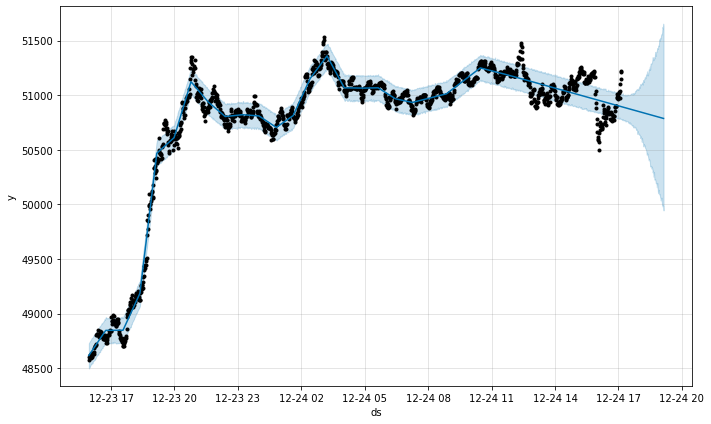

In [130]:
fig1 = m.plot(forecast)